In [1]:
# Data management
import pandas as pd

# Data preprocessing and trasformation (ETL)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, load_iris, make_moons, make_classification


# Math and Stat modules
import numpy as np
from scipy.stats import sem
from random import choice

# Supervised Learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

# Unsupervised Learning

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Prepariamo velocemente i dati

In [2]:
credit_card_data = pd.read_csv('../ETLinSKLearn/BankChurnersMissingData.csv')
credit_card_data.dropna(subset=['Total_Revolving_Bal','Months_Inactive_12_mon'],
                   inplace=True
                  )

# Estraggo la  colonna delle label e la rimuovo dal dataset
credit_card_label = credit_card_data['Attrition_Flag'].map(
    {'Existing Customer':0,
     'Attrited Customer':1
    }
).values
credit_card_data.drop(columns=['Attrition_Flag',
                               'CLIENTNUM',
                               'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
                               'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'],
                      inplace=True)

In [3]:
def unknown_imputer(X, missing_value = 'Unknown'):
    X = X.values
    unique_values, count = np.unique(X,return_counts=True)
    num_nan = count[unique_values == missing_value]
    counting = count[unique_values != missing_value]
    values = unique_values[unique_values != missing_value]
    X_new = X.copy()
    freq = counting / np.sum(counting)
    X_new[X_new == missing_value] = np.random.choice(values,size=num_nan,p=freq)
    return X_new

ui = FunctionTransformer(unknown_imputer)

customer_age_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

category_pipeline = Pipeline([
    ('imputer', FunctionTransformer(unknown_imputer)),
    ('ordinal', OneHotEncoder())
])

features_robust = ['Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy']
features_standard = list(set(credit_card_data.select_dtypes(include=['int64','float64']).columns).difference(set(features_robust + ['Avg_Utilization_Ratio', 'Customer_Age'])))

In [4]:
data_preprocessing = ColumnTransformer([
    ('age', customer_age_pipeline, ['Customer_Age']),
    ('gender', OrdinalEncoder(categories=[['M','F']]), ['Gender']),
    ('edu', category_pipeline, ['Education_Level']),
    ('status', category_pipeline, ['Marital_Status']),
    ('income', category_pipeline, ['Income_Category']),
    ('card', category_pipeline, ['Card_Category']),
    ('numeric_robust', RobustScaler(), features_robust),
    ('feature_standard', StandardScaler(), features_standard)
],
    remainder = 'passthrough'
)

In [5]:
feature_matrix = data_preprocessing.fit_transform(credit_card_data)

In [6]:
feature_matrix.shape

(10125, 33)

In [6]:
columns_name = ['Customer_Age','Gender']
for c in ['Education_Level','Marital_Status','Income_Category']:
    cat_inc_name = [c+'_cat{}'.format(i) for i in range(1,len(credit_card_data[c].unique()))]
    columns_name.extend(cat_inc_name)
columns_name.extend(['Card_Category_cat{}'.format(i) for i in range(1,len(credit_card_data['Card_Category'].unique())+1)])
columns_name.extend(features_robust)
columns_name.extend(features_standard)
columns_name.append('Avg_Utilization_Ratio')

In [8]:
columns_name

['Customer_Age',
 'Gender',
 'Education_Level_cat1',
 'Education_Level_cat2',
 'Education_Level_cat3',
 'Education_Level_cat4',
 'Education_Level_cat5',
 'Education_Level_cat6',
 'Marital_Status_cat1',
 'Marital_Status_cat2',
 'Marital_Status_cat3',
 'Income_Category_cat1',
 'Income_Category_cat2',
 'Income_Category_cat3',
 'Income_Category_cat4',
 'Income_Category_cat5',
 'Card_Category_cat1',
 'Card_Category_cat2',
 'Card_Category_cat3',
 'Card_Category_cat4',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Trans_Ct',
 'Contacts_Count_12_mon',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Dependent_count',
 'Months_Inactive_12_mon',
 'Months_on_book',
 'Total_Relationship_Count',
 'Total_Amt_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

# Classificazione

Ora siamo pronti per addestrare un semplice modello di ML e lo potremmo fare piuttosto facilmente grazie al fatto che abbiamo gia' preparato i dati in modo da essere facilmente utilizzabili dagli oggetti di tipo **Predictor**.

Utilizziamo come modello base il **Perceptron**. Il perceptron rappresenta la prima rete neurale - non possiamo sicuramente definire come ''deep''. L'algoritmo di apprendimento restituisce (se converge 😀) un vettore di pesi. Nella formulazione base, l'unico iperparametro e' il **learning rate** $\eta$.

In SKL il modello e' implementato dalla classe **Perceptron**, un tipo di Predictor. La documentazione completa della classe si trova [qui](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html).

Iniziamo a definire un Perceptron utilizzando tutti i valori di default.

In [24]:
perceptron = Perceptron()
perceptron.fit(feature_matrix, credit_card_label)

Perceptron()

Il metodo **fit** implementa l'algoritmo di training in cui il vettore dei pesi viene modificato in base al learning rate e agli errori di classificazione durante il processo di addestramento.

Vediamo come si comporta con alcuni elementi del training set.

In [25]:
sample_training = feature_matrix[:10,:]
sample_labels = credit_card_label[:10]
prediction_sample = perceptron.predict(sample_training)
for i in range(len(sample_labels)):
    print(i, 'True label : {}, Predicted Label: {}'.format(sample_labels[i],prediction_sample[i]))

0 True label : 0, Predicted Label: 0
1 True label : 0, Predicted Label: 0
2 True label : 0, Predicted Label: 0
3 True label : 0, Predicted Label: 0
4 True label : 0, Predicted Label: 0
5 True label : 0, Predicted Label: 0
6 True label : 0, Predicted Label: 0
7 True label : 0, Predicted Label: 0
8 True label : 0, Predicted Label: 0
9 True label : 0, Predicted Label: 0


Un risultato che potrebbe sembrare incoraggiante...

Proviamo a contare quante volte sbaglio su un set di dati gia' visto...

In [29]:
all_predicted = perceptron.predict(feature_matrix)

In [31]:
np.sum(all_predicted == credit_card_label)/len(credit_card_label)

0.8899753086419753

Non sembra male, ma ...

In [32]:
all_predicted_dummy = np.zeros(len(credit_card_label))
np.sum(all_predicted_dummy == credit_card_label)/len(credit_card_label)

0.8393086419753086

Il perceptron performance un po' meglio di un modello "in tilt", cioe' un modello che predice sempre la classe piu' frequente.

Questa piccola differenza di performance ci permette di introdurre alcune trappole in cui siamo caduti. 
1) La valutazione delle performance deve essere effettuata su dati non ancora 'visti' dall'algoritmo di apprendimento (errore metodologico);
2) La valutazione deve tenere conto del bilanciamento o meno delle classi (aspetto piu' complesso da gestire)

In questa fase, esploriamo il **primo** problema.

## Cross-validation
Le metodologie di cross-validation possono essere utili per ottenere delle valutazioni piu' attendibili circa le proprieta' di **generalizzazione** del modello appreso, cioe' quanto il modello sara' in grado di **predirre correttamente la classe di appartenenza su dati non ancora osservati** - obiettivo finale del nostro task.

Per prevenire il primo errore, e  di conseguenza l'overfitting dei dati, una pratica comune e' la **holdout cross-validation**. Si divide il dataset in due insiemi distinti: training e test dataset. Il primo e' usato per l'addestramento del modello, il secondo per la valutazione delle performance e la valutazione delle capacita' di generalizzazione.

![](training_test.png)

Un raffinamento del precedente schema e' l'utilizzo di un terzo insieme: **validation set**, grazie al quale viene fatto una model selection, i.e. vengono identificati l'insieme degli iperparametri ottimali. <br>
In questo modo ho il vantaggio di non utilizzare il test set nella fase di learning riducendo il bias sulla stima della capacita' di generalizzare su nuovi dati.

![](training_validation_test.png)

Il modo in cui gli insiemi vengono partizionati influenza la stima delle performance. Per aumentare la robustezza della stima possiamo utilizzare **k-fold cross validation**.

Prima, pero', vediamo come fare holdout cross-validation in SKL. SKL mette a disposizione il metodo **train_test_split** che mi restituisce una partizione in training e test sia della matrice delle feature sia del vettore delle label. E' possibile specificare la frazione di elementi che costituiscono i due insiemi.

Nel nostro caso, il training set e' costituito dal 70% del campione.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, credit_card_label, test_size = 0.3, random_state = 42)

In [36]:
X_train.shape, X_test.shape

((7087, 33), (3038, 33))

In [37]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train) # apprendo su training
predicted_test = perceptron.predict(X_test) # predico sul test
np.sum(predicted_test == y_test)/len(y_test)

0.8834759710335747

In [38]:
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(feature_matrix, credit_card_label, test_size = 0.3)
    perceptron = Perceptron()
    perceptron.fit(X_train, y_train) # apprendo su training
    predicted_test = perceptron.predict(X_test) # predico sul test
    print(np.sum(predicted_test == y_test)/len(y_test))

0.8739302172481896
0.8640552995391705
0.8531928900592495
0.7919684002633312
0.8633969716919025
0.8759052007899935
0.8601053324555629
0.8736010533245556
0.8828176431863067
0.8574720210664911


### k-fold Cross-validation

Nella k-fold cross-validation - *k-fold CV* - il training set viene suddiviso in $k$ sottoinsiemi disgiunti - *fold* , dove per ogni fold $f$:
1) i rimanenti $k-1$ fold sono utilizzati come training set
2) il modello addestrato sui $k-1$ fold viene valutato sulla parte rimanente del dataset, cioe' $f$.

In questo modo si ottengono $k$ modelli e $k$ misure di performance diverse. Si calcola, quindi una media delle performance. Una volta selezionato l'insieme degli iperparametri migliori, si riaddestra il modello sul training set completo e si effettua la valutazione del test set.

![](kfold-cross_validation.png)

Attraverso il metodo [**cross_val_score**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score#sklearn.model_selection.cross_val_score) possiamo usare direttamente k-CV e ottenere le misure di performance per ogni fold.

Solitamente come valore da assegnare a $k$ si usa **5** o **10**, a seconda della dimensione del dataset. In SKL, se $K$ e' un intero vengono utilizzate le classi **KFold** o **StratifiedKFold**, come strategie di partizionamento di default (nota: la strategia basata sulla stratificazione verra' analizzata in seguito, in questo notebook).

In [39]:
perceptron = Perceptron()
perceptron_score = cross_val_score(perceptron, X_train, y_train, cv = 5)
perceptron_score

array([0.83145275, 0.88293371, 0.8659139 , 0.87720536, 0.85179958])

In [40]:
np.mean(perceptron_score)

0.8618610604855605

Approfondiremo le misure di performance in seguito.

Come vedremo il parametro **cv** ammette come valori accettabbili, tipi di dato diverso, in modo da specificare quale strategia di divisione del set utilizzare in forma di classi SKL o iterable su un insieme di indici.

Una funzione simile a *cross_val_score* e' **cross_val_predict**. Restituisce per ogni elemento nel training set, la label predetta quando quell'elemento era nel fold di test.

In [43]:
cross_val_predict(perceptron, X_train, y_train, cv = 5).shape

(7087,)

### Cross Validation Iterators
La generazione delle fold dipende fortemente dal metodo di partizionamento/campionamento adottato e dalle assunzioni sul tipo di dato presente nel dataset.

Se assumiamo che i dati siano i.i.d.  - indipendenti e identicamente distribuiti - il processo generativo dei dati e' unico e non ha memoria dei dati generati in passato. 

In questo caso possiamo utilizzare:
- k-fold
- Repeated k-fold
- LOO
- LPO
- Shuffle and Split

La classe **KFold** implementa il k-fold splitting della k-fold CV. Vedi https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

In [9]:
p = Perceptron()
kf = KFold(n_splits=10)
cross_val_score(p, X_train, y_train, cv = kf)

array([0.8674189 , 0.8674189 , 0.83779972, 0.88575458, 0.87165021,
       0.84626234, 0.86177715, 0.84180791, 0.81073446, 0.86864407])

Mediante il metodo **split** posso ottenere l'insieme dei fold di training e il fold di test, espressi come indici della feature matrix. In sostanza indica quali righe inserire nel fold di training e quali inseire nel fold di test.

In [15]:
all_cls = []
for train_idx, test_idx in kf.split(X_train, y_train):
    x_train_fold, y_train_fold = X_train[train_idx,:], y_train[train_idx]
    p = Perceptron()
    p.fit(x_train_fold, y_train_fold)
    print(p.coef_)
    x_val_fold, y_val_fold = X_train[test_idx,:], y_train[test_idx]
    fold_predicted = p.predict(x_val_fold)
    print(np.sum(fold_predicted == y_val_fold)/len(y_val_fold))
    all_cls.append(p)
all_cls[3]

p_all = Perceptron()
p_all.fit(X_train, y_train)
p_all.predict(X_test)[:10]

[[  2.11192662   4.          -6.           0.          -1.
    0.          -1.          -4.          -4.          -4.
   -4.          -3.          -5.           0.           0.
   -4.          -4.          -4.           1.          -5.
    0.23462171  -4.52213633   1.26803      0.4180946   -2.30161514
    0.39368749  -3.80520232   1.65851149 -15.02805396   6.48086251
    4.04939982  -0.80088207   0.66      ]]
0.8674188998589563
[[  1.32477671   2.           1.          -2.          -5.
   -2.           1.          -1.          -3.          -3.
   -2.           0.          -4.          -4.           1.
   -1.          -4.          -1.          -1.          -2.
   -3.4387218   -9.10400562  -1.72546584   1.48399923  -0.42861642
   -2.57556399  -8.40807656   1.36232157 -15.94158444   8.03833993
    6.65752759  -2.24968872   0.956     ]]
0.8674188998589563
[[ -0.71224369   4.           0.          -2.          -3.
   -2.           0.           0.          -2.          -4.
   -1.           4

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0], dtype=int64)

Possiamo notare come nell'esempio precedente sul perceptron, i valori di performance possono oscillare ed influenzare la performance media. 

Una soluzione per ridurre l'effetto delle oscillazioni nel calcolo della performance media e' ripetere la k-fold CV per diverse volte e riportare la performance media calcolata su tutti i fold di tutte le ripetizioni. Ovviamente, il partizionamento tra due ripetizioni non e' lo stesso.<br>
Questo approccio e' utile con dataset di piccola/media dimensione e che non richiedono un elevato costo di computazione nella fase di training, anche se e' facile parallelizzare il processo (SKL lo fa di default)

SKL fornisce un'implementazione di tale metodo mediante la classe **RepeatedKFold** (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold). Si devono specificare i valori di $K$ e il numero di ripetizioni *n_repeats*.

In [13]:
rkf = RepeatedKFold(n_splits=10, n_repeats=3)
cross_val_score(p, X_train, y_train, cv = rkf)

array([0.88857546, 0.85754584, 0.86318759, 0.78984485, 0.89562764,
       0.82369535, 0.87306065, 0.83474576, 0.90536723, 0.85028249,
       0.8674189 , 0.89562764, 0.84062059, 0.80394922, 0.88152327,
       0.87165021, 0.85895628, 0.86440678, 0.87853107, 0.84887006,
       0.87729196, 0.89421721, 0.88011283, 0.87306065, 0.88011283,
       0.88293371, 0.85190409, 0.89548023, 0.85451977, 0.88700565])

Da notare il parametro *n_jobs* tramite cui specifico quanti core utilizzare in parallelo per eseguire CV.

E' possibile anche valutare l'effetto del numero di ripetizioni sulle performance medie del classificatore.

{'whiskers': [<matplotlib.lines.Line2D at 0x16fa7263df0>,
 'caps': [<matplotlib.lines.Line2D at 0x16fa7264520>,
 'boxes': [<matplotlib.lines.Line2D at 0x16fa7263070>,
 'medians': [<matplotlib.lines.Line2D at 0x16fa72646d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x16fa7b1f190>,
 'means': [<matplotlib.lines.Line2D at 0x16fa7b1f5b0>,
  <matplotlib.lines.Line2D at 0x16fa7c0aeb0>]}

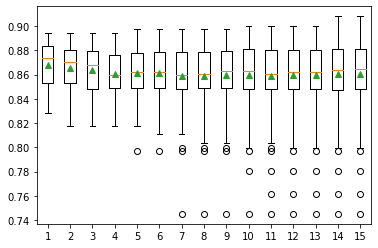

In [17]:
def valuta_modello_ripetizione(X, y, repeats):
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    model = Perceptron()
    scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    return scores

repeats = range(1,16)
results = list()
for i in repeats:
    scores = valuta_modello_ripetizione(feature_matrix, credit_card_label, i)
    results.append(scores)
plt.boxplot(results, labels = [str(i) for i in repeats], showmeans=True)

Sempre nel setting iid, possiamo generare un insieme di split training/test in cui viene violata la condizione di insieme disgiunto tra le fold. In questo caso appliciamo una random permutation CV.

In SKL tale strategia e' fornita dalla classe **ShuffleSplit**. Per ogni iterazione - splitting, la feature matrix viene permutata e una sua frazione di righe viene assegnata al test set.

In [19]:
spf = ShuffleSplit(n_splits = 10, test_size = 0.25)
perceptron_score = cross_val_score(p, X_train, y_train, cv = spf, n_jobs=-1)
perceptron_score.mean()

0.848081264108352

In questo modo si ha un controllo maggiore sulla porzione di elementi nel test e si perde la dipendenza tra $k$ e *test_size*

#### Stratification
In alcuna situazione assistiamo - come nel nostro caso - ad un forrte sbilanciamento nella distribuzione delle classi nel vettore delle label. In questi casi si raccomanda di utilizzare un campionamento stratitificato implementato dalle classi SKL **StratifiedKFold** e **StratifiedShuffleSplit**. Tali classi assicurano che la distribuzione delle etichette in ogni fold approssimi quella dell'intero vettore delle etichette

Nel caso di StratifiedKFold avremo la suddivisione in figura:

![](stratified_kfold_cv.png)

In [20]:
kf = KFold(n_splits=10)
skf = StratifiedKFold(n_splits=10)
print('----K-fold CV----------')
for train, test in kf.split(feature_matrix, credit_card_label):
    y_train, y_test = credit_card_label[train], credit_card_label[test]
    print('Train: {:.2f} vs Test: {:.2f}'.format(sum(y_train == 1)/len(y_train), sum(y_test == 1)/len(y_test)))
print('----Stratified K-fold CV-------')
for train, test in skf.split(feature_matrix, credit_card_label):
    y_train, y_test = credit_card_label[train], credit_card_label[test]
    print('Train: {:.2f} vs Test: {:.2f}'.format(sum(y_train == 1)/len(y_train), sum(y_test == 1)/len(y_test)))

----K-fold CV----------
Train: 0.17 vs Test: 0.10
Train: 0.17 vs Test: 0.07
Train: 0.17 vs Test: 0.05
Train: 0.16 vs Test: 0.14
Train: 0.16 vs Test: 0.21
Train: 0.15 vs Test: 0.21
Train: 0.16 vs Test: 0.21
Train: 0.16 vs Test: 0.20
Train: 0.16 vs Test: 0.15
Train: 0.15 vs Test: 0.25
----Stratified K-fold CV-------
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16


Lo stesso principio si applica alla metodologia di shuffle and split:

![](stratified_shufflesplit_cv.png)

## Performance Measure for Classification

Viste le diverse strategie di cross-validation, affrontiamo un secondo argomento essenziale: le misure di performance.

Abbiamo gia' visto che il perceptron utilizzato in precedenza non era meglio di un classificatore che prediceva sempre l'etichetta piu' frequente.

In [22]:
mf_dum_cls = DummyClassifier(strategy='most_frequent')
uni_dum_cls = DummyClassifier(strategy='uniform')
st_dum_cls = DummyClassifier(strategy='stratified')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, credit_card_label, test_size=0.3, random_state=45)

In [24]:
cross_val_score(mf_dum_cls, X_train, y_train, cv=10, scoring='accuracy').mean()

0.8388599364107957

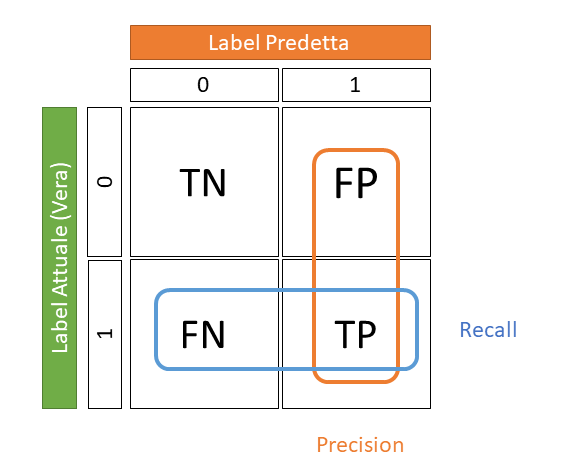Cio' mostra come l'accuracy non e' una buona misura di performance, specialmente quando il vettore delle etichette e' sbilanciato.

Un modo migliore per valutare le performance di un classificatore e' la **confusion matrix** $C$. L'elemento $C_{ij}$ della matrice corrisponde al numero di osservazioni che hanno etichetta $i$ e che sono state classificate con etichetta $j$. Nel caso di classificazione binario:
1) $C_{00}$ = veri negativi
2) $C_{01}$ = falsi positivi
3) $C_{10}$ = falsi negativi
4) $C_{11}$ = veri positivi

![](confusion_matrix.png)

Per calcolare la confusion matrix, necessitiamo di:
1) il vettore delle etichette
2) il vettore delle etichette predette

Per ottenere il secondo elemento possiamo utilizzare il metodo  *cross_val_predict*

In [25]:
y_train_predicted = cross_val_predict(p, X_train, y_train, cv = 10)

Infine per calcolare la confusion matrix utilizziamo il metodo **confusion matrix**.

In [26]:
confusion_matrix(y_train, y_train_predicted)

array([[5311,  634],
       [ 478,  664]], dtype=int64)

Ogni riga corrisponde ad una classe _attuale_, mentre ogni colonna una _classe predetta_.

Dalla matrice di confusione posso calcolare l'accuratezza delle predizioni positive, i.e. la **precision**:
$$precision = \frac{C_{11}}{C_{11} + C_{01}} = \frac{TP}{TP + FP}$$

a cui si accompagna un'altra metrica: la **recall** o **sensitivity** o **true positive rate**:
$$recall = \frac{C_{11}}{C_{11} + C_{10}} = \frac{TP}{TP + FN}$$

In SKL precision e recall sono restituite dai metodi **precision_score** e **recall_score**

In [27]:
precision_score(y_train, y_train_predicted)

0.5115562403697997

In [28]:
recall_score(y_train, y_train_predicted)

0.5814360770577933

Vediamo le differenze confrontandoci con i due dummy classifier definiti in precedenza

In [29]:
y_train_mf = cross_val_predict(mf_dum_cls, X_train, y_train, cv = 10)
y_train_un = cross_val_predict(uni_dum_cls, X_train, y_train, cv = 10)
y_train_st = cross_val_predict(st_dum_cls, X_train, y_train, cv = 10)

In [31]:
precision_score(y_train, y_train_mf), precision_score(y_train, y_train_un), precision_score(y_train, y_train_st)

C:\Users\matte\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.1578204404291361, 0.17106382978723406)

Nel caso di dummy che predice la singola classe piu' frequente, la colonna nella confusion matrix relativa alla classe 1 e' composta da 0 => 0/0. Nei rimanenti casi, si puo' intuire il risultato se pensiamo al processo di classificazione implementato come una selezione. Nel caso predica 1, seleziono l'elemento del campione e mi chiedo quale sia la sua etichetta. In entrambi i casi vengono rispettate le proporzioni della classe nel campione originario. In un caso seleziono meno elementi (stratified), perche' le etichette sono sbilanciate.

In [32]:
recall_score(y_train, y_train_mf), recall_score(y_train, y_train_un), recall_score(y_train, y_train_st)

(0.0, 0.489492119089317, 0.17600700525394045)

Nel primo caso la recall e' 0 perche' $C_{11}=0$. Per spiegare i rimanenti risultati, si selezionano i campioni con etichetta vera = 1, nel caso uniforme ottengo il 50% di elementi con etichetta 1, nel caso stratified ottengo solo il 16% con etichetta 1.

In [33]:
confusion_matrix(y_train, y_train_un)

array([[2962, 2983],
       [ 583,  559]], dtype=int64)

In [34]:
confusion_matrix(y_train, y_train_st)

array([[4971,  974],
       [ 941,  201]], dtype=int64)

Sia in recall che precision, il perceptron si comporta leggermente meglio di un random guesser.

In generale *una soluzione basata su perceptron non e' affidabile nel caso mi segnali un cliente 'in uscita', e neanche in grado di identificare un cliente 'in uscita'*.

Per avere un modo semplice per confrontare due classificatori, viene spesso impiegato l'indicatore $F_{1}$, definito come la media armonica tra precision e recall. Penalizza un classificatore con precision e recall sbilanciate.
$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}$. Questo indicatore viene implementato dal metodo **f1_score**

In [35]:
f1_score(y_train, y_train_predicted)

0.5442622950819672

### Precision/Recall Tradeoff
Utilizziamo ora un logit classifier per il problema dell'identificazione dei churner dal momento che restituisce anche un **prediction score**. Nel caso del classificatore in questione, corrisponde al valore prima della funzione di threshold, i.e. $\phi(\mathbf{w}^T\mathbf{x})$. Esso indica la confidenza sulla classe predetta. In SKL un logit classifier e' implementato dalla classe **LogisticRegression**, il quale rende disponibile il metodo **decision_function** per ottenere gli score di confidenza associati ad ogni istanza predetta.

In questo modo possiamo agire sulla funzione di soglia e modificare la predizione finale.

In [9]:
logit_cls = LogisticRegression(max_iter=1000)
y_scores = cross_val_predict(logit_cls, X_train, y_train, cv = 10, method='decision_function')

Dato gli score, possiamo utilizzare il metodo **precision_recall_curve** per calcolare precision e recall al variare del valori di soglia

In [10]:
prec, recall, soglia = precision_recall_curve(y_train, y_scores)

In [18]:
# Metodo alternativo per il calcolo degli score
logit_cls.fit(X_train, y_train)
y_scores_alternative = logit_cls.decision_function(X_train)

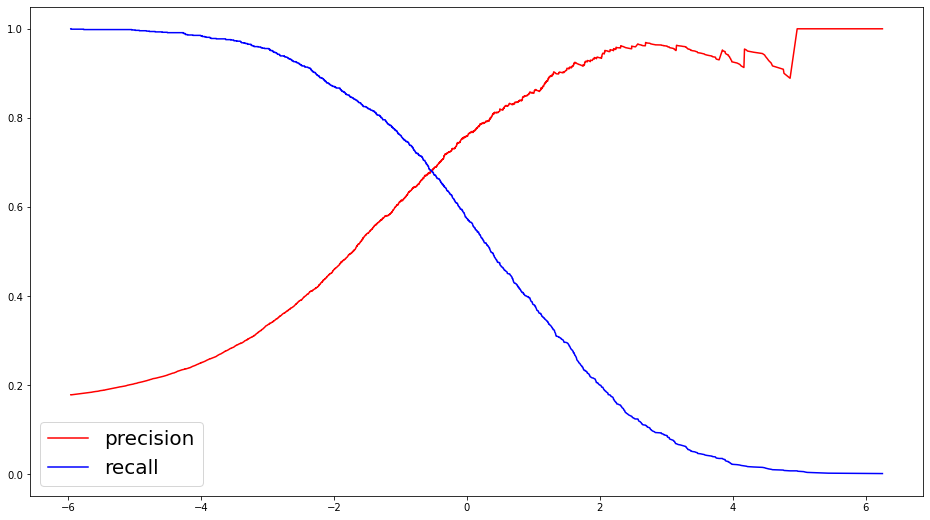

In [12]:
fig_prc = plt.figure(figsize=(16,9))
ax = fig_prc.add_subplot()
ax.plot(soglia, prec[:-1], 'r', label = 'precision')
ax.plot(soglia, recall[:-1], 'b', label = 'recall')
ax.legend(fontsize=20)

Oppure posso visualizzare la precision in funzione della recall

Text(0, 0.5, 'Precision')

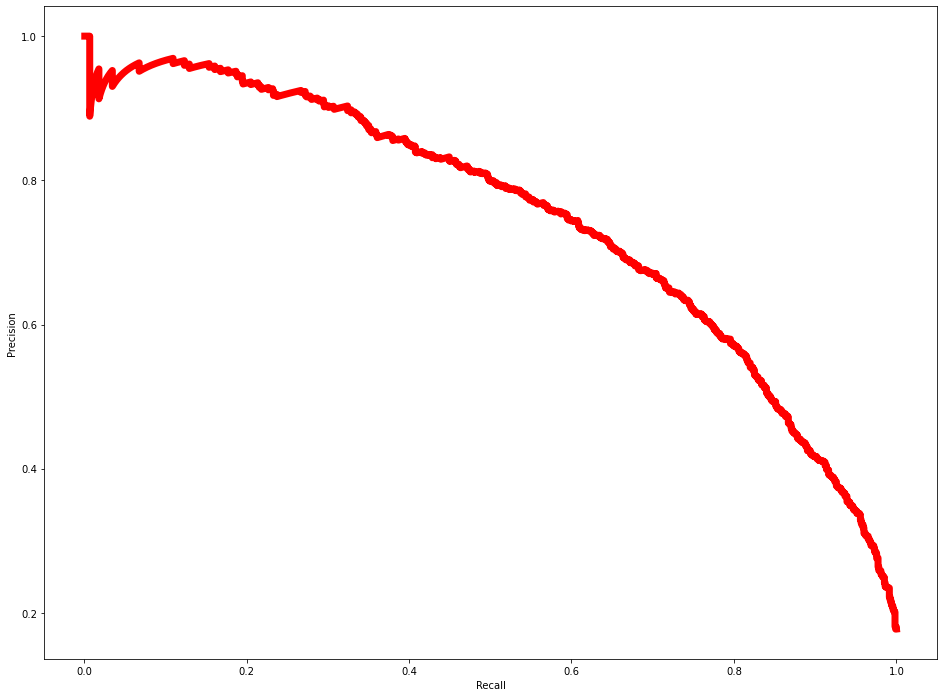

In [15]:
fig_prf = plt.figure(figsize=(16,12))
ax = fig_prf.add_subplot()
ax.plot(recall[:-1], prec[:-1], 'r', label = 'precision', lw = 7)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

Questo tipo di analisi ci permette di scegliere il valore in base alle nostre esigenze. Per esempio se volessimo aumentare la precision fino a 0.9 ...

In [21]:
soglia_prec_90 = soglia[np.argmax(prec >= 0.9)]
y_predicted_score = y_scores >= soglia_prec_90
precision_score(y_train, y_predicted_score), recall_score(y_train, y_predicted_score), f1_score(y_train, y_predicted_score)

(0.9009661835748792, 0.3243478260869565, 0.47698209718670076)

### ROC Curve
La curva **Receiver operating characteristic - ROC** e' molto simile alla curva precision/recall ma visualizza la recall in funzione del **false positive rate**:
$$FPR = \frac{C_{01}}{C_{01}+C_{00}} = \frac{FP}{FP+TN} = 1 - specificity$$
Per visualizzare la curva ROC applichiamo lo stesso procedimento precedente utilizzo il metodo **roc_curve**.

In [22]:
fpr, recall, soglia = roc_curve(y_train, y_scores)

Text(0, 0.5, 'Recall')

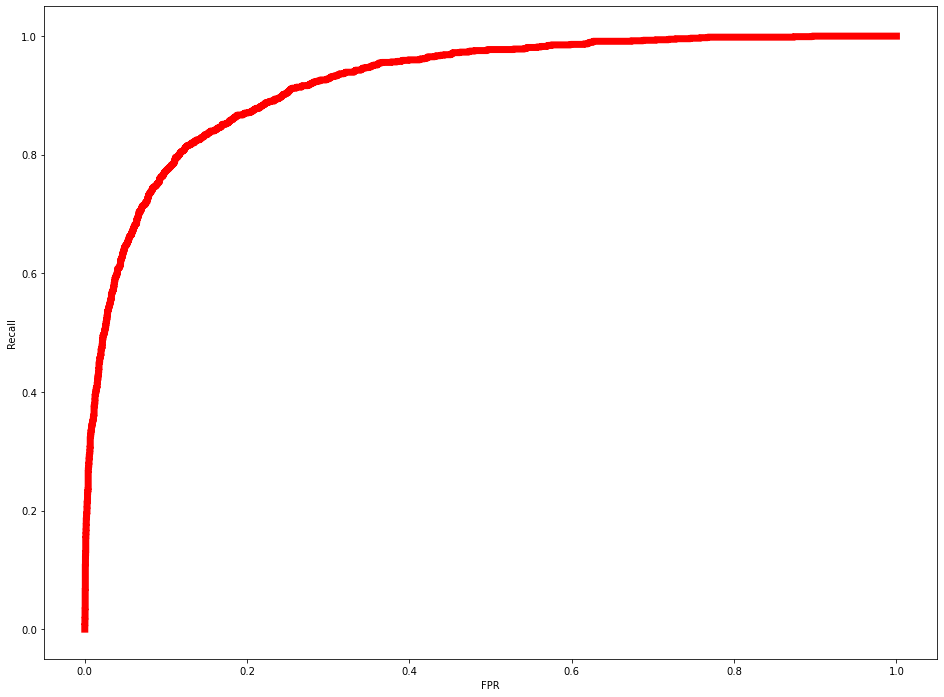

In [24]:
fig_roc = plt.figure(figsize=(16,12))
ax = fig_roc.add_subplot()
ax.plot(fpr, recall, 'r', label = 'recall', lw = 7)
ax.set_xlabel("FPR")
ax.set_ylabel("Recall")

All'aumentare della recall, aumenta la produzione di falsi positivi.

### Learning and validation curve
Learning e validation curve  sono altri semplici strumenti per la valutazione delle performance e l'identificazio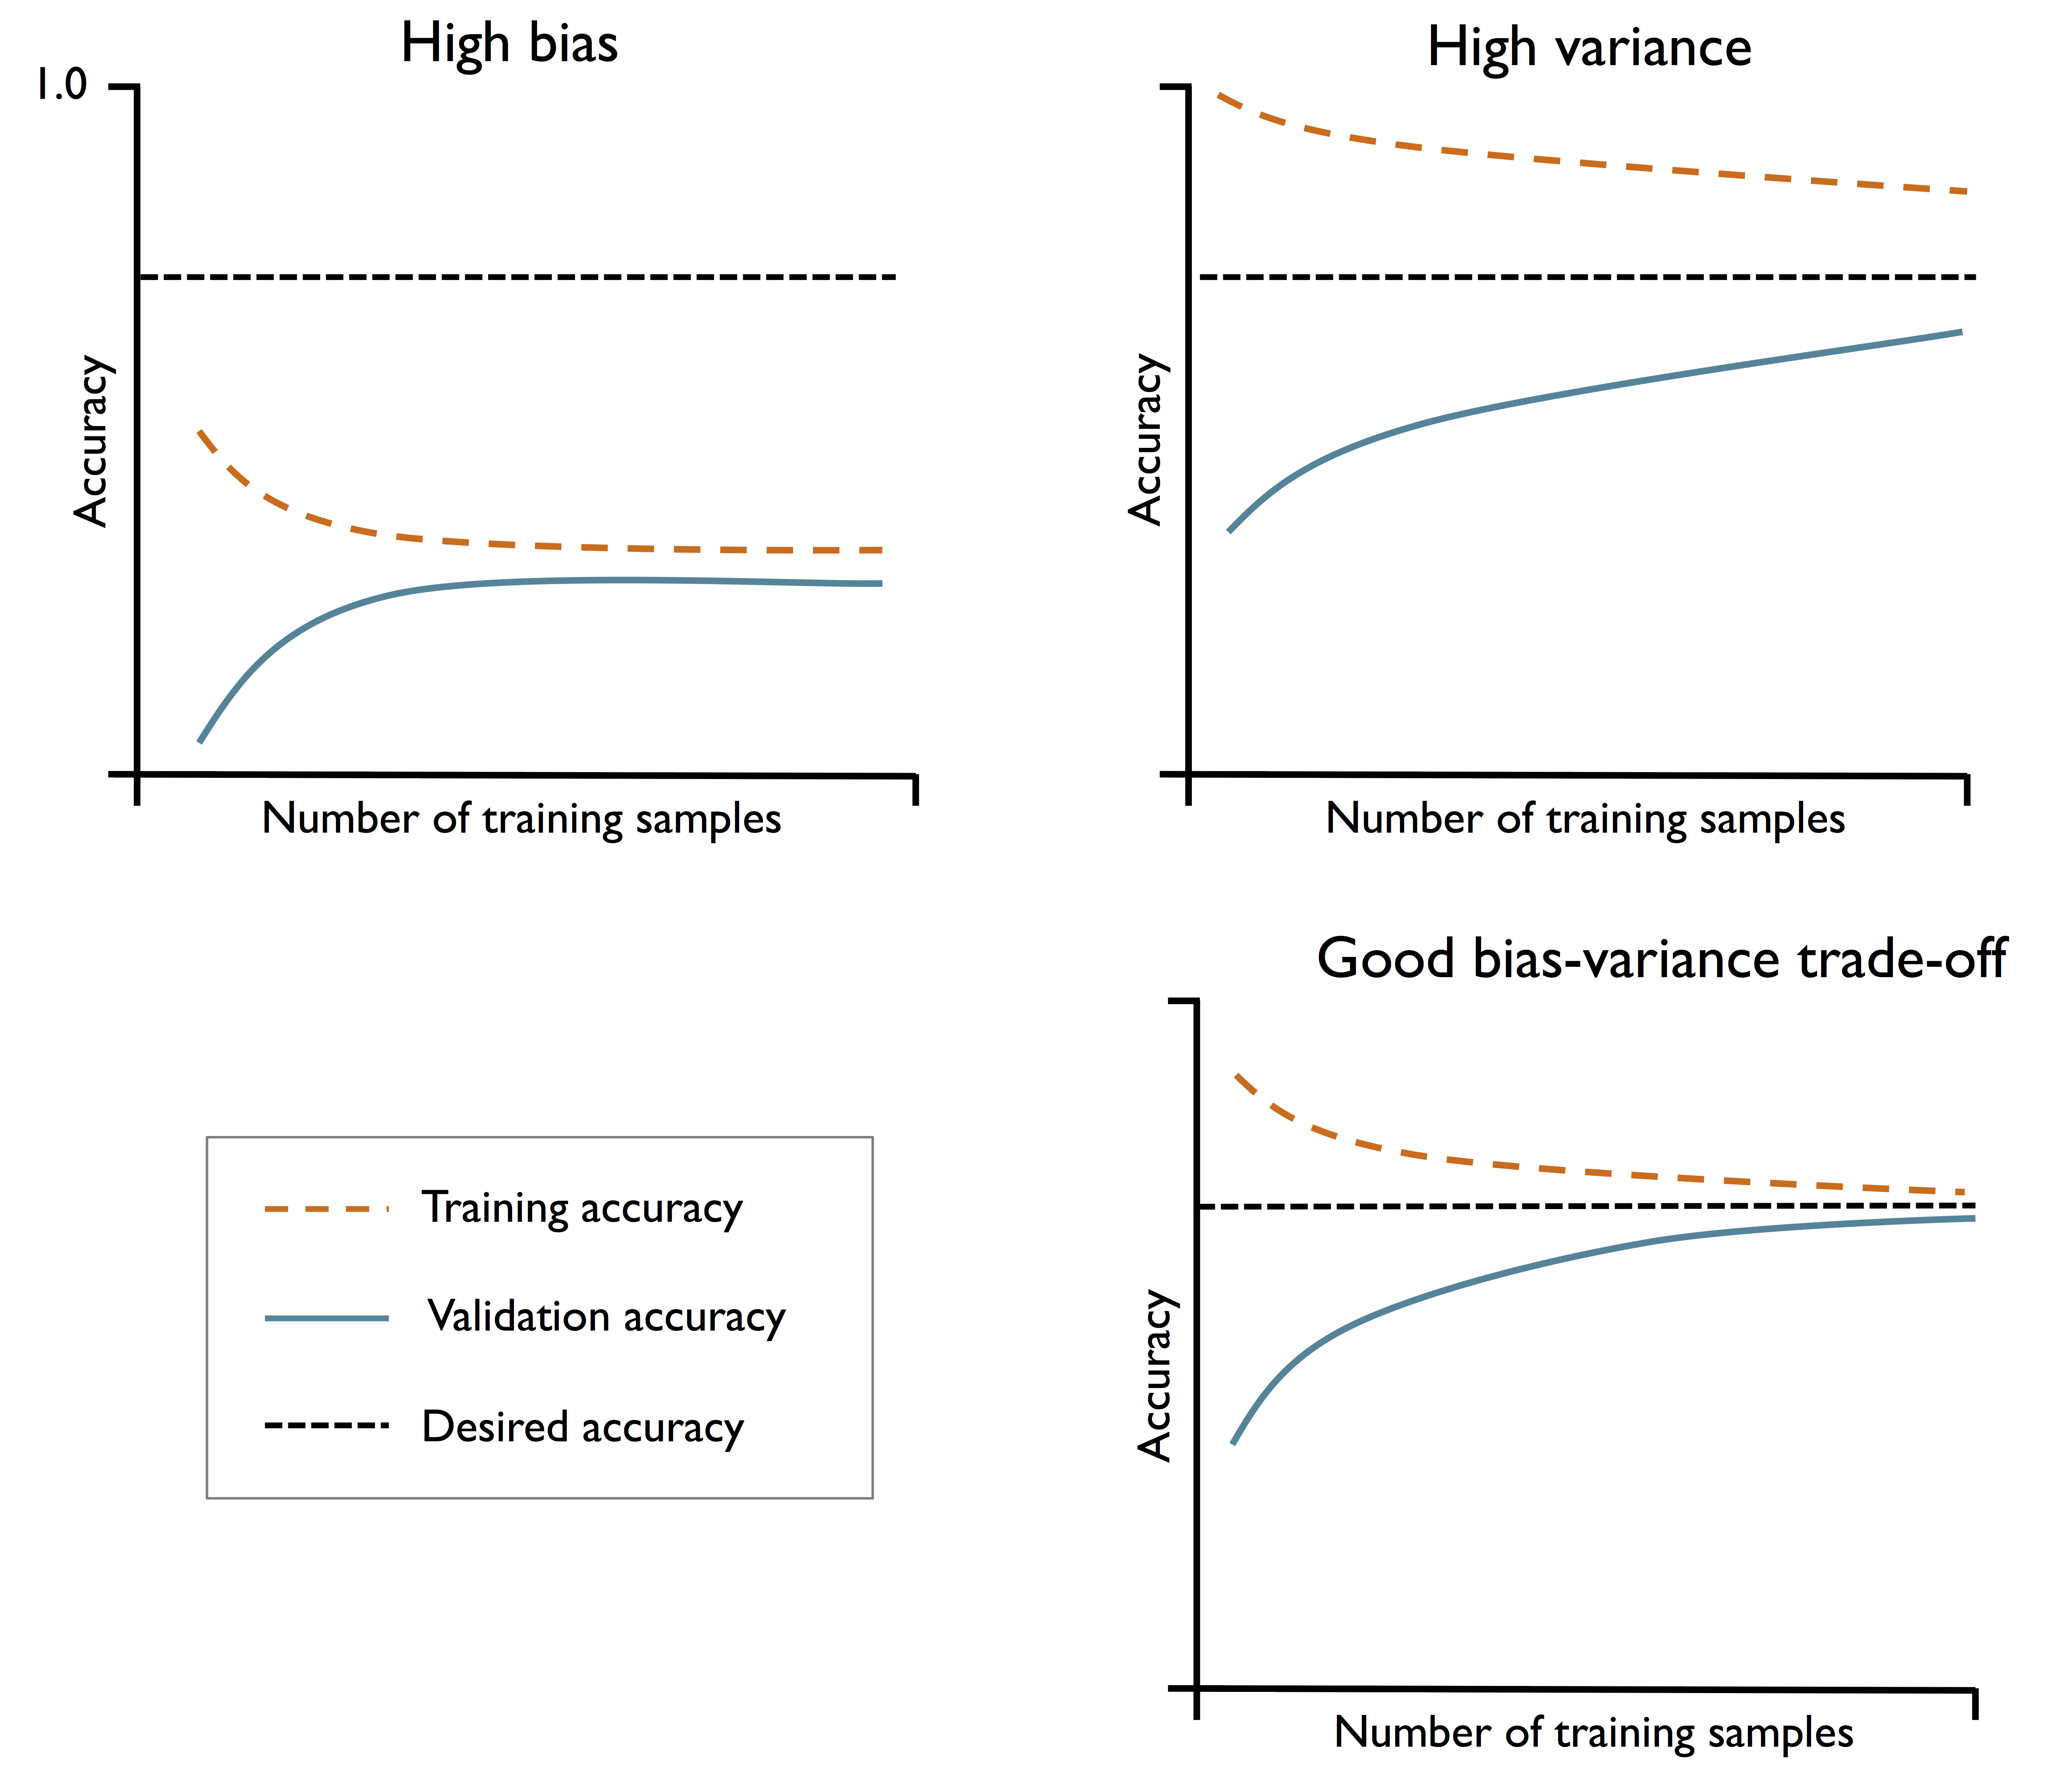ne di problemi di overfitting o underfitting

se un modello e' troppo complesso, il modello tende a overfittare sui dati e non generalizza bene. In questo caso puo' aiutare aumentare la dimensione del training set - molto spesso non e' una soluzione attuabile. In questo caso si possono visualizzare le accuracy del training e del validation set in funzione della dimensione del training set = *learning curve* 

![](bias-variance.png)

Nel primo caso abbiamo un modello con un bias elevato in quanto TS e V accuracy sono rispetto al target -> passare ad un modello con meno assunzioni, oppure aumentare grado di liberta' del modello (cfr. regolarizzazione). In questo caso abbiamo underfitting.

Nel secondo caso abbiamo un alta varianza, in quanto raggiungiamo l'accuracy "possibile" ma esiste un gap tra TS e V accuracy. In questo caso abbiamo overfitting -> collezionare piu' training data, ridurre la complessita' del modello o introdurre regolarizzazione, oppure feature selection.

In SKL posso valutare la learning curve mediante il metodo **learning_curve**.

In [7]:
logit_cls = LogisticRegression(max_iter = 1000)

In [64]:
train_sizes, train_scores, test_scores = learning_curve(logit_cls,
                                                       X=feature_matrix,
                                                       y=credit_card_label,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 10,
                                                       n_jobs = -1,
                                                       shuffle = True)

(0.6, 1.03)

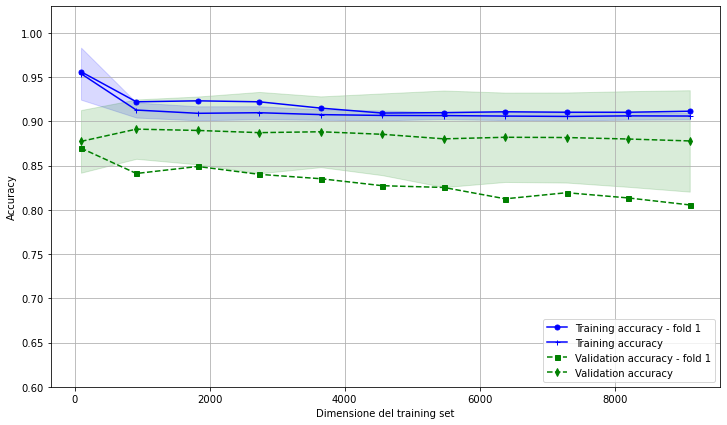

In [65]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(train_sizes, train_scores[:,0],
         color='blue', marker='o',
         markersize=5, label='Training accuracy - fold 1')

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_scores[:,0],
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy - fold 1')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Dimensione del training set')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 1.03])

In [56]:
train_sizes[0]

91

Un ulteriore strumento di valutazione di problemi di over/under-fitting e' la **validation curve**. In questo caso, si varia il valore dei parametri del modello.

Nel caso di LogisticRegression, il parametro $C$ e' l'inverso del parametro di regolarizzazione $\lambda$. All'aumentare del valore di C, diminuisce l'effetto di regolarizzazione, diminuisco la varianza

In SKL posso valutare la validation curve mediante il metodo **validation_curve**.

In [12]:
range_C = [0.001,0.01,0.1,1,10.100]
train_scores, test_scores = validation_curve(logit_cls, X=feature_matrix, y=credit_card_label, param_range=range_C, param_name='C',cv=10, n_jobs=-1)

(0.0, 1.03)

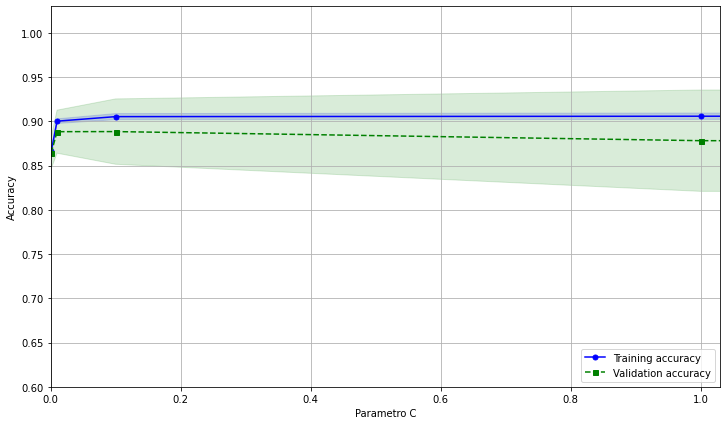

In [10]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parametro C')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 1.03])
ax.set_xlim([0., 1.03])

In questo caso per valori di C superiori a 0.01, inizia un fenomeno di overfitting indicato da una differenza crescente tra accuracy nel training e accuracy nella validation.

# Multiclass classification

La classificazione multiclasse e' applicabile in un contesto in cui il label vector assume piu' di due valori discreti. Alcuni algoritmi di ML sono in grado di gestire un vettore multiclasse (Random Forest e Naive Bayes), mentre alcuni sono strettamente binari (SVM, Linear Classifier). In questo caso esistono una serie di strategie da applicare ad un problema di classificazione multiclasse utilizzando classificatori binari:
1. OvA (one-versus-all): si addesstrano N classificatore, uno per ognuna delle N classi. Per ognuno degli N classificatori, si considera lo score di classificazione ottenuto, e si restituisce la classe associata allo score con valore massimo.
2. OvO (one-versus-one): si addestrano $N(N-1)/2$ classficiatori, uno per ogni coppia di classi. Per classificare un nuovo campione, si applicano tutti i classificatori e si restituisce la classe che vince piu' round di classificazione.

Dal punto di vista computazionale, il primo approccio e' piu' efficiente  - N contro $N^2$ - rispetto a OvO, tranne nel caso in cui l'algoritmo di apprendimento non e' efficiente in funzione del numero di campioni $M$. Nel caso di OvA, la complessita' e' $NM$, mentre nel caso di OvO la complessita' e' $(N-1)M$ nel caso di label vector bilanciato, tuttavia, in caso di architettura multi-core si possono apprendere i classificatori nel confronto OvO in modo parallelo.


In SKL tutti i classificatori implementano nativamente la classificazione multiclass. Nel caso si volesse sperimentare con una soluzione diversa da quella di default il modulo **multiclass** rende disponibili due classi **OneVsRestClassifier** e **OneVsOneClassifier**, che rispettivamente implementano OvA e OvO. Il costruttore della classe accetta un qualsiasi oggetti di tipo classifier.

Per questo tipo di classificazione utilizziamo il data MNIST, il quale contiene come campione delle immagini

In [13]:
from sklearn.datasets import fetch_openml

In [14]:
def random_instance(X):
    size = X.shape[0]
    return X[np.random.choice(np.arange(size))]

In [16]:
X_mnist, y_mnist = fetch_openml('mnist_784', version = 1, return_X_y = True, as_frame=False)

In [17]:
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.15, random_state=42)

In [18]:
perceptron = Perceptron()
perceptron.fit(X_mnist_train, y_mnist_train)

Perceptron()

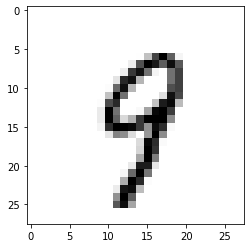

['9']


In [19]:
random_digit = random_instance(X_mnist_train).reshape(28,28)
plt.imshow(random_digit, cmap = mpl.cm.binary)
plt.show()
print(perceptron.predict(random_digit.reshape(1,-1)))

Posso ottenere tutti gli score delle varie classi utilizzando il metodo **decision_function**

In [22]:
rd_scores = perceptron.decision_function(random_digit.reshape(1,-1))
rd_scores

array([[-16961038., -11821604., -13657536.,  -4139919.,  -6779929.,
         -5869680., -12165596.,  -3908870.,  -1339937.,   1722733.]])

E controllare la classe con lo score maggiore.

In [23]:
perceptron.classes_[np.argmax(rd_scores)]

'9'

Utilizziamo ora la classe **OneVsOneClassifier** per creare una strategia di decisione dell'etichetta diversa

In [24]:
ovo = OneVsOneClassifier(Perceptron(max_iter=5, tol=-np.infty, random_state=42))
ovo.fit(X_mnist_train, y_mnist_train)
ovo.predict(random_digit.reshape(1,-1))

array(['9'], dtype=object)

Posso accedere a tutti i classificatori binari sulle coppie mediante l'attributo **estimators_**

In [26]:
len(ovo.estimators_)

45

## Error analysis

In [27]:
y_test_predicted = ovo.predict(X_mnist_test)
confusion = confusion_matrix(y_mnist_test, y_test_predicted)

In [28]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

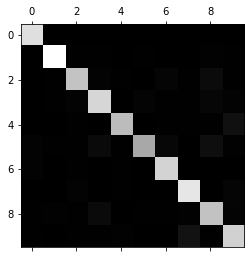

In [29]:
plt.matshow(confusion, cmap=plt.cm.gray)

In [30]:
normalized_confusion_matrix = confusion / confusion.sum(axis=1, keepdims=True)

In [31]:
np.fill_diagonal(normalized_confusion_matrix,0)

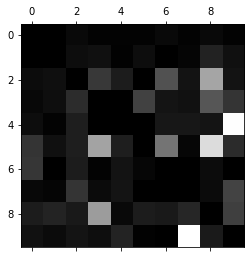

In [32]:
plt.matshow(normalized_confusion_matrix, cmap=plt.cm.gray)